In [1]:
from string import ascii_uppercase
from tqdm import tqdm
import random
import pickle

import pandas as pd
import matplotlib.pyplot as plt

import torch

from sentence_transformers.util import semantic_search, dot_score, normalize_embeddings
from transformer_lens import HookedTransformer

torch.manual_seed(42);

/home/jgcarrasco/.virtualenvs/mech_interp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**What are we trying to do?:** Automatically generating adversarial samples to detect and understand possible vulnerabilities on circuits associated to specific tasks. In this case, we are studying the task of three-letter acronym prediction. First, we will try to generate samples that are **incorrectly predicted by the model**, i.e. certain samples or letters that are incorrectly predicted, hence detecting possible vulnerabilities.

In [2]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True
)

Loaded pretrained model gpt2-small into HookedTransformer


In [3]:
# tokens of capital letters
cap_tokens = model.to_tokens([x for x in ascii_uppercase], prepend_bos=False)[:, 0]
cap_tokens_space = model.to_tokens([" " + str(x) for x in ascii_uppercase], prepend_bos=False)[:, 0]
# as we are taking a subset of the vocabulary, we also enumerate them in order 
# (e.g 'A' is the token 32, but is enumerated as 0 on the subspace, etc.)
idx_to_token = {k:v.item() for k, v in enumerate(cap_tokens)}
token_to_idx = {v.item():k for k, v in enumerate(cap_tokens)}
space_to_no_space = {k.item():v.item() for k,v in zip(cap_tokens_space, cap_tokens)}
no_space_to_space = {k.item():v.item() for k,v in zip(cap_tokens, cap_tokens_space)}

In [4]:
# indices of the token containing the first/second/third capital letters
indices_letters = [2, 3, 4]
# same for the acronym letter -1 (this is where the corresponding logit is stored)
indices_logits = [5, 6, 7]
# letter that we want to modify: 0, 1 or 2
letter = 2

In [5]:
with open("data/acronyms.txt", "r") as f:
   prompts, acronyms = list(zip(*[line.split(", ") for line in f.read().splitlines()]))

# take a subset of the dataset (we do this because VRAM limitations)
n_samples = 1000
# giga-cursed way of sampling from the dataset
prompts, acronyms = list(map(list, zip(*random.choices(list(zip(prompts, acronyms)), k=n_samples))))

tokens = model.to_tokens(prompts)
# ground truth: third letter of the acronym (tokens)
y = model.to_tokens([x[letter] for x in acronyms], prepend_bos=False).squeeze()
with torch.no_grad():
    y_pred = model(tokens)[:, indices_logits[letter]].argmax(dim=-1)
# discard already misclassified samples
tokens = tokens[y_pred == y]
y = y[y_pred == y]
# reupdate n_samples
n_samples = tokens.shape[0]

y_idx = y.cpu().apply_(token_to_idx.get).cuda()

In [6]:
batch_size = 128

# randomly sample batch_size initial samples
idx = torch.randint(0, n_samples, (batch_size,))
sample_tokens = tokens[idx]
sample_y = y[idx]
sample_y_idx = y_idx[idx]
sample_embeddings = model.W_E[sample_tokens].clone().detach()
sample_embeddings.requires_grad = True

sample_tokens.shape, sample_embeddings.shape, sample_y.shape, sample_y_idx.shape

(torch.Size([128, 8]),
 torch.Size([128, 8, 768]),
 torch.Size([128]),
 torch.Size([128]))

In [7]:
def project_embeddings(sample_embeddings, embedding_matrix, vocab, mask):
    """
    Given a batch of sample adversarial embeddings, project 
    them into their closest token in the embedding space.

    Input:
    - `sample_embeddings`: Tensor of shape (batch_size, seq_len, d_model)
    - `embedding_matrix`: Tensor of shape (d_vocab, d_model)
    - `vocab`: Tensor of shape (n_vocab,), where n_vocab <= d_vocab, containing
        the list of possible tokens when projecting/updating the samples. The reason
        for this is that, for example, when generating acronyms, we might not want to
        change a capital letter to a non-capital letter, i.e. we want to stay inside a 
        concrete vocabulary.
    - `mask`: Tensor of shape (seq_len,). mask[i] = 1 means that the i-th token will be 
    optimized/changed by the algorithm.

    Returns:

    Two tensors containing both the ids and the embedding vectors of the projected vectors.
    - `projected_tokens`: Tensor of shape (batch_size, seq_len)
    - `projected_embeddings`: Tensor of shape (batch_size, seq_len, d_model)
    """
    vocab_embedding_matrix = normalize_embeddings(embedding_matrix[vocab])
    # project the sample embeddings, i.e. find the closest embedding pertaining to a real token
    result = semantic_search(normalize_embeddings(sample_embeddings.view(-1, sample_embeddings.shape[-1])), # flatten the batch size and pos dimensions and normalize 
                vocab_embedding_matrix, 
                query_chunk_size=sample_embeddings.shape[0], top_k=1,
                score_function=dot_score)
    projected_tokens = torch.tensor([vocab[x[0]["corpus_id"]] for x in result]).cuda()
    projected_tokens = projected_tokens.view(sample_embeddings.shape[:-1]) # (batch_size, seq_len)
    projected_tokens = torch.where(mask, projected_tokens, sample_tokens) # project only the tokens specified by the mask
    projected_embeddings = embedding_matrix[projected_tokens].clone().detach()
    return projected_tokens, projected_embeddings

embedding_matrix = model.W_E
# now the vocabulary of optimization is every single token word possible
with open("data/words_dict.pkl", 'rb') as f:
    words_dict = pickle.load(f)
word_list = [v for _, v in words_dict.items()]
word_list = [x for xs in word_list for x in xs]
vocab = model.to_tokens(word_list, prepend_bos=False)[:, 0]

mask = torch.zeros(sample_tokens.shape[-1], dtype=torch.bool).cuda()
mask[indices_letters[letter]] = 1

projected_tokens, projected_embeddings = project_embeddings(sample_embeddings, embedding_matrix, vocab, mask)
torch.equal(projected_tokens, sample_tokens), torch.equal(projected_embeddings, sample_embeddings)

(True, True)

In [8]:
def AdvMarginLoss(margin=1.0):
    """
    Create the adversarial Margin Loss
    """
    def loss_fn(logits, y, average=True):
        """
        Return the adversarial margin loss used to generate adversarial samples.

        Parameters:
        - `logits`: Tensor of shape (batch_size, num_classes) containing the logits.
        - `y`: Tensor of shape (batch_size,) containing the index of the ground truth.
        """
        # gather the logits of the ground truth
        logits_correct = logits[torch.arange(0, logits.shape[0]), y] # (batch_size,)
        # retrieve the maximum logits of the incorrect answers
        y_incorrect = torch.ones_like(logits, dtype=bool)
        y_incorrect[torch.arange(0, logits.shape[0]), y] = 0
        max_logits_incorrect = logits[y_incorrect].view(logits.shape[0], -1).max(1).values # (batch_size,)
        loss = (logits_correct - max_logits_incorrect + margin)
        loss = torch.where(loss < 0, torch.zeros_like(loss), loss)

        return loss.mean() if average else loss

    return loss_fn

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:14<00:00, 13.44it/s]


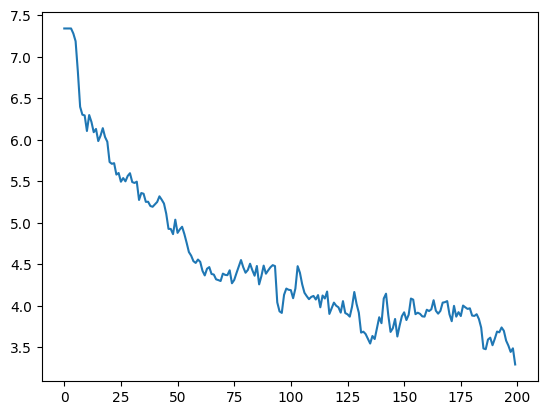

In [9]:
# First test: start with an initial sample, modify just the third capital letter to minimize the adversarial loss, i.e.
# use our algorithm to automatically generate samples that incorrectly predict the third letter, DESPITE being valid sentences!

batch_size = 128

# randomly sample batch_size initial samples
idx = torch.randint(0, n_samples, (batch_size,))
sample_tokens = tokens[idx]
sample_y = y[idx]
sample_y_idx = y_idx[idx]
sample_embeddings = model.W_E[sample_tokens].clone().detach()
sample_embeddings.requires_grad = True

embedding_matrix = model.W_E

# now the vocabulary of optimization is every single token word possible
with open("data/words_dict.pkl", 'rb') as f:
    words_dict = pickle.load(f)
word_list = [v for _, v in words_dict.items()]
word_list = [x for xs in word_list for x in xs]
vocab = model.to_tokens(word_list, prepend_bos=False)[:, 0]

mask = torch.zeros(sample_tokens.shape[-1], dtype=torch.bool).cuda()
mask[indices_letters[letter]] = 1

lr=1e-1
weight_decay=1e-1
margin = 4
loss_fn = AdvMarginLoss(margin=margin)

input_optimizer = torch.optim.AdamW([sample_embeddings], lr=lr, weight_decay=weight_decay)

# we will collect the adversarial samples: samples that are incorrectly classified by the model
adv_samples = []
# we also collect the original sample associated to each adversarial sample
original_samples = []
losses = []
# OPTIMIZE
for _ in tqdm(range(200), disable=False):

    # Project the embeddings
    projected_tokens, projected_embeddings = project_embeddings(sample_embeddings, embedding_matrix, vocab, mask)
    # BRUH this is causing a high bottleneck. Optimize when everything works right
    sample_y_idx = torch.tensor([token_to_idx[model.to_tokens(model.to_string(x[indices_letters[letter]])[1], prepend_bos=False).item()] for x in projected_tokens], dtype=torch.long).cuda()

    tmp_embeddings = sample_embeddings.detach().clone()
    tmp_embeddings.data = projected_embeddings.data
    tmp_embeddings.requires_grad = True

    # Take the logits of the subspace
    logits_vocab = model.forward(tmp_embeddings + model.pos_embed(projected_tokens), start_at_layer=0)[:, indices_logits[letter], cap_tokens]

    loss = loss_fn(logits_vocab, sample_y_idx, average=True)

    sample_embeddings.grad, = torch.autograd.grad(loss, [tmp_embeddings])
    # set the gradient of elements outside the mask to zero
    sample_embeddings.grad = torch.where(mask[None, ..., None], sample_embeddings.grad, 0.) 
    input_optimizer.step()
    input_optimizer.zero_grad()
    #print(loss.item())
    #print(model.to_string(projected_tokens))
    losses.append(loss.item())

    with torch.no_grad():
        # Re-project the embeddings
        projected_tokens, projected_embeddings = project_embeddings(sample_embeddings, embedding_matrix, vocab, mask)
        sample_y_idx = torch.tensor([token_to_idx[model.to_tokens(model.to_string(x[indices_letters[letter]])[1], prepend_bos=False).item()] for x in projected_tokens], dtype=torch.long).cuda()
        # check if there are adversarial samples
        # Take the logits of the subspace
        logits_vocab = model.forward(projected_embeddings + model.pos_embed(projected_tokens), start_at_layer=0)[:, indices_logits[letter], cap_tokens]

        loss_i = loss_fn(logits_vocab, sample_y_idx, average=False)
        adv_samples.append(projected_tokens[loss_i < margin]) # a loss lower than margin implies that the sample is incorrectly classified
        original_samples.append(sample_tokens[loss_i < margin])

adv_samples = torch.cat(adv_samples, dim=0)
original_samples = torch.cat(original_samples, dim=0)
adv_samples, inverse_indices = torch.unique(adv_samples, sorted=False, dim=0, return_inverse=True)
original_samples_unique = torch.zeros_like(adv_samples)
original_samples_unique[inverse_indices] = original_samples[torch.arange(0, original_samples.shape[0])]
original_samples = original_samples_unique
plt.plot(losses)

In [10]:
adv_samples.shape[0]

390

In [11]:
model.cpu()
adv_token_preds = model(adv_samples)[:, indices_logits[letter], cap_tokens.cpu()].argmax(-1).cpu().apply_(idx_to_token.get)
original_token_preds = model(original_samples)[:, indices_logits[letter], cap_tokens.cpu()].argmax(-1).cpu().apply_(idx_to_token.get)


for a, b, c, d in zip(model.to_string(adv_samples[:, :indices_logits[letter]+1]), model.to_string(adv_token_preds), model.to_string(original_samples[:, :indices_logits[letter]+1]), model.to_string(original_token_preds)):
    print(c, "->",d)
    print(a, "->",b)
    print("-"*40)

Moving model to device:  cpu
<|endoftext|>The President Verb Jewel (PV -> J
<|endoftext|>The President Verb Amazon (PV -> N
----------------------------------------
<|endoftext|>The President Verb Jewel (PV -> J
<|endoftext|>The President Verb Docker (PV -> N
----------------------------------------
<|endoftext|>The President Verb Jewel (PV -> J
<|endoftext|>The President Verb Cisco (PV -> N
----------------------------------------
<|endoftext|>The President Verb Jewel (PV -> J
<|endoftext|>The President Verb Ogre (PV -> N
----------------------------------------
<|endoftext|>The President Verb Jewel (PV -> J
<|endoftext|>The President Verb Pluto (PV -> N
----------------------------------------
<|endoftext|>The President Verb Jewel (PV -> J
<|endoftext|>The President Verb Ares (PV -> N
----------------------------------------
<|endoftext|>The President Verb Jewel (PV -> J
<|endoftext|>The President Verb Corsair (PV -> N
----------------------------------------
<|endoftext|>The Sam Zed

In [12]:
unique_tokens, count = torch.unique(torch.tensor([model.to_tokens(model.to_string(x)[1], prepend_bos=False).item() for x in adv_samples[:, indices_letters[letter]]], dtype=torch.long), return_counts=True)
unique_caps = model.to_string(unique_tokens)

adv_freq_dict = {}
for c in ascii_uppercase:
    adv_freq_dict[c] = 0

A = []
B = []
for a, b in zip(unique_caps, count):
    adv_freq_dict[a] = b.item()

In [13]:
# save the adversarial samples (note that we discard those whose acronyms are not properly tokenized as 3 tokens!)
with open(f"data/{letter}_adv_acronyms.txt", "a") as f:
    for sentence in model.to_string(adv_samples[:, 1:]):
        acronym = (''.join([c for c in sentence if c.isupper()]))[1:-2]
        if model.to_tokens(acronym, prepend_bos=False).shape[1] == 3:
            f.write(sentence + ", " + acronym + "\n")

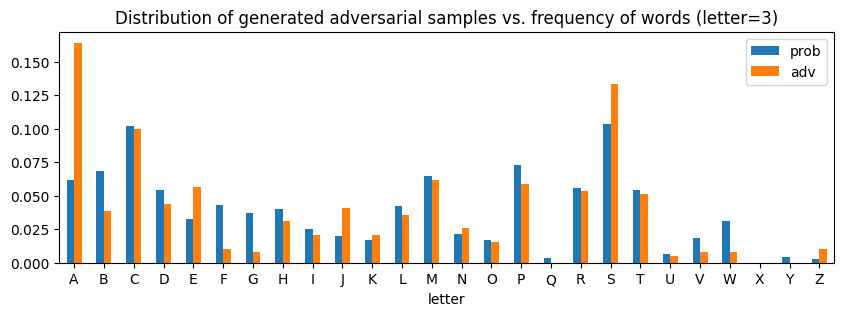

In [14]:
with open("data/words_dict.pkl", 'rb') as f:
        words_dict = pickle.load(f)

prob_dict = {}

n_words = sum([len(v) for _, v in words_dict.items()])

# get the probability of sampling a word beginning by each letter
for k, v in words_dict.items():
    prob_dict[k] = float(len(v)) / n_words

df = pd.DataFrame({"letter": list(ascii_uppercase), "prob": list(prob_dict.values()), "adv": list(adv_freq_dict.values())})
df["adv"] = df["adv"] / df["adv"].sum()
df.plot.bar(x="letter", rot=0, figsize=(10, 3), title=f"Distribution of generated adversarial samples vs. frequency of words (letter={letter+1})");

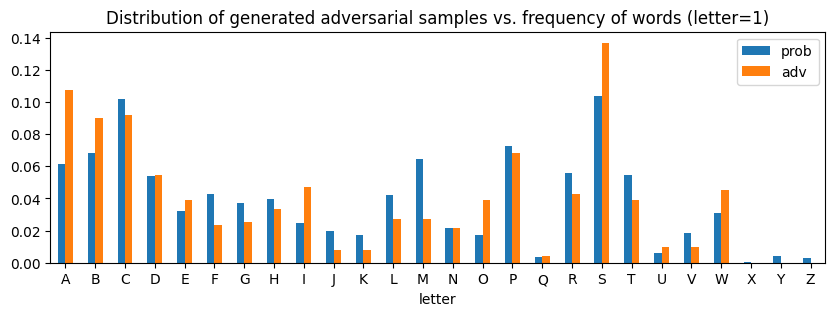

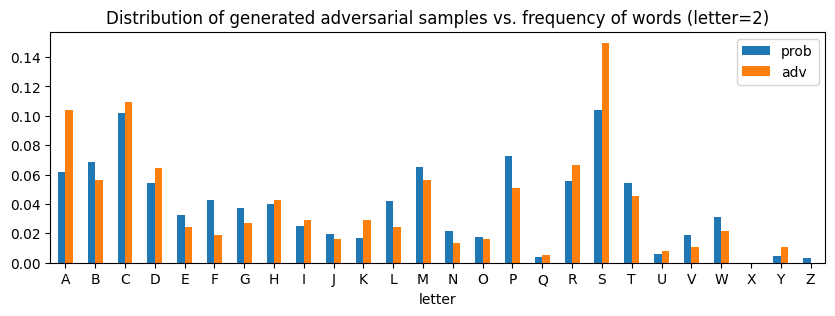

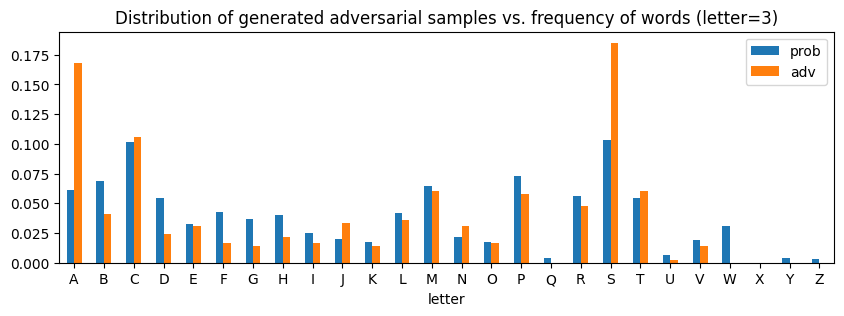